# Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond

In this iPython notebook I implement a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to solve a navigation task in a basic grid world. To learn more, read here: https://medium.com/p/8438a3e2b8df

For more reinforcment learning tutorials, see:
https://github.com/awjuliani/DeepRL-Agents

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### Load the game environment

Feel free to adjust the size of the gridworld. Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.

In [2]:
class gameOb():
    def __init__(self,x,y,size,intensity,channel):
        self.x = x
        self.y = y
        self.size = size
        self.intensity = intensity
        self.channel = channel
        
class gameEnv():
    def __init__(self):
        self.sizeX = 6
        self.sizeY = 6
        self.actions = 4
        a = self.reset()
        plt.imshow(a,interpolation="nearest")
        
        
    def reset(self):
        xList = range(self.sizeX)
        yList = range(self.sizeY)
        Xs = np.random.choice(xList,replace=False,size=3)
        Ys = np.random.choice(yList,replace=False,size=3)
        hero = gameOb(Ys[0],Xs[0],1,1,2)
        bug = gameOb(Ys[1],Xs[1],1,1,1)
        hole = gameOb(Ys[2],Xs[2],1,1,0)
        state = self.renderEnv([bug,hero,hole])
        self.objects = [bug,hero,hole]
        self.state = state
        return state

    def moveChar(self,objects,direction):
        # 0 - up, 1 - down, 2 - left, 3 - right
        bug,hero,hole = objects[0],objects[1],objects[2]
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY-2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX-2:
            hero.x += 1        
        return [bug,hero,hole]

    def checkGoal(self,objects):
        bug,hero,hole = objects[0],objects[1],objects[2]
        if hero.x == bug.x and hero.y == bug.y:
            return 1.,True
        elif hero.x == hole.x and hero.y == hole.y:
            return -1.,True
        else:
            return 0,False

    def renderEnv(self,objects):
        a = np.zeros([self.sizeY,self.sizeX,3])
        for item in objects:
            a[item.y:item.y+item.size,item.x:item.x+item.size,item.channel] = item.intensity
        b = scipy.misc.imresize(a[:,:,0],[84,84,1],interp='nearest')
        c = scipy.misc.imresize(a[:,:,1],[84,84,1],interp='nearest')
        d = scipy.misc.imresize(a[:,:,2],[84,84,1],interp='nearest')
        a = np.stack([b,c,d],axis=2)
        return a

    def step(self,action):
        objects = self.moveChar(self.objects,action)
        state = self.renderEnv(objects)
        reward,done = self.checkGoal(objects)
        return state,reward,done

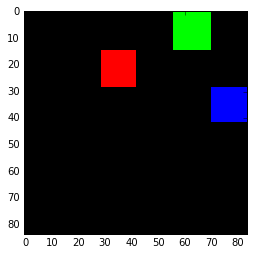

In [3]:
env = gameEnv()

Above is an example of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green square (for +1 reward) and avoid the red square (for -1 reward). The position of the three blocks is randomized every episode.

### Implementing the network itself

In [ ]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = tf.contrib.layers.convolution2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d( \
            inputs=self.conv3,num_outputs=512,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(3,2,self.conv4)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size/2,env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size/2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.sub(self.Advantage,tf.reduce_mean(self.Advantage,reduction_indices=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.mul(self.Qout, self.actions_onehot), reduction_indices=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Experience Replay

This class allows us to store experies and sample then randomly to train the network.

In [ ]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

This is a simple function to resize our game frames.

In [ ]:
def processState(states):
    return np.reshape(states,[21168])

This function allows us to update the parameters of our target network with those of the primary network.

In [ ]:
def updateTarget(tfVars,sess):
    total_vars = len(tfVars)
    for idx,var in enumerate(tfVars[0:total_vars/2]):
        sess.run(tfVars[idx+total_vars/2].assign(var.eval()))

This function allows us to discount our rewards for a given episode. This approach is called the Monte-Carlo method, since we apply it to all the rewards in a given episode. We will be using it in order to provide a more robust reward signal to the DQN.

In [ ]:
gamma = 0.99

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

### Training the network

Setting all the training parameters

In [ ]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 50000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 50000 #How many steps of random actions before training begins.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.

In [ ]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.initialize_all_variables()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    if load_model == True:
        print 'Loading Model...'
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    sess.run(init)
    updateTarget(trainables,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < 200: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
            
                if total_steps % (update_freq*1000) == 0:
                    print "Target network updated."
                    updateTarget(trainables,sess)
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
            rAll += r
            s = s1
            
            if d == True:

                break
        
        #Get all experiences from this episode and discount their rewards.
        episodeRewards = np.array(episodeBuffer.buffer)[:,2]
        discountRewards = discount_rewards(episodeRewards)
        bufferArray = np.array(episodeBuffer.buffer)
        bufferArray[:,2] = discountRewards
        episodeBuffer.buffer = zip(bufferArray)
        #Add the discounted experiences to our experience buffer.
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print "Saved Model"
        if len(rList) % 10 == 0:
            print total_steps,np.mean(rList[-10:]), e
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"

### Checking network learning

Mean reward over time

In [ ]:
rMat = np.resize(np.array(rList),[len(rList)/100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)

Episode length over time

In [ ]:
jMat = np.resize(np.array(jList),[len(jList)/100,100])
jMean = np.average(jMat,1)
plt.plot(jMean)